### 单个策略在不同数据集的表现

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import pandas as pd
from lumina.genetic.signal.method import *
from lumina.genetic.strategy.method import *
from ultron.factor.genetic.geneticist.operators import *
from lumina.genetic.fusion.orders import profit_std, profit_rate, position_next_order_cy
from lumina.genetic.fusion.orders.state import order_rate
from lumina.genetic.metrics.ts_pnl import calculate_ful_ts_pnl

In [3]:
from kdutils.macro2 import *
from kdutils.file import fetch_file_data

In [4]:
method = 'aicso2'
g_instruments = 'ims'

In [5]:
total_data = fetch_file_data(base_path=base_path,
                             method=method,
                             g_instruments=g_instruments,
                             datasets=['train_data','val_data','test_data'])
total_data.head()

#filename = os.path.join(base_path, method, g_instruments, 'merge',
#                            "train_data.feather")
#factors_data = pd.read_feather(filename).sort_values(
#        by=['trade_time', 'code'])
#rootid = INDEX_MAPPING[INSTRUMENTS_CODES[g_instruments]]
#factors_data['trade_time'] = pd.to_datetime(factors_data['trade_time'])
#factors_data = factors_data.set_index('trade_time')

#total_data = factors_data

,trade_time,code,fz002_10_15_0,fz002_10_15_1,fz002_5_10_0,fz002_5_10_1,gd002_10_15_0,gd002_10_15_1,gd002_5_10_0,gd002_5_10_1,...,tf022_5_10_0,tf022_5_10_1,close,high,low,open,value,volume,openint,vwap
0,2022-07-25 09:30:00,IM,0.000005,0.000012,1.510336e-07,0.000011,0.514307,0.535732,0.638363,0.594229,...,6960.738199,6965.166142,6974.2,6974.2,6974.2,6974.2,78111040.0,56.0,17477.0,6974.200000
1,2022-07-25 09:31:00,IM,0.000004,0.000014,-5.022059e-07,0.000019,0.519601,0.490171,0.577894,0.474407,...,6962.646048,6965.797137,6973.8,6994.8,6964.4,6971.8,848911040.0,608.0,17333.0,6981.176316
2,2022-07-25 09:32:00,IM,0.000004,0.000023,5.013559e-06,0.000050,0.505921,0.437287,0.506818,0.366650,...,6965.278947,6967.786373,6982.8,6995.2,6969.6,6973.8,597671840.0,428.0,17268.0,6982.147664
3,2022-07-25 09:33:00,IM,0.000006,0.000033,1.808164e-05,0.000077,0.482672,0.387361,0.415001,0.283643,...,6970.107860,6972.851800,6989.8,6989.8,6981.6,6982.8,391195160.0,280.0,17213.0,6985.627857
4,2022-07-25 09:34:00,IM,0.000008,0.000042,3.322211e-05,0.000094,0.453396,0.340788,0.309016,0.219035,...,6976.463962,6976.334521,6993.0,6993.0,6982.6,6989.6,447271480.0,320.0,17123.0,6988.616875


In [6]:
total_data['trade_time'] = pd.to_datetime(total_data['trade_time'])

In [7]:
strategy_settings = {
        'capital': 10000000,
        'commission':0.00023,# COST_MAPPING[INSTRUMENTS_CODES[g_instruments]],
        'slippage': 0,#SLIPPAGE_MAPPING[INSTRUMENTS_CODES[g_instruments]],
        'size': CONT_MULTNUM_MAPPING[INSTRUMENTS_CODES[g_instruments]]
    }

In [8]:
total_data1 = total_data.set_index(['trade_time'])
total_data2 = total_data.set_index(['trade_time', 'code']).unstack()

total_dt = total_data2.copy()

In [9]:
def build_strategy(total_data1,
                   total_data2,
                   total_dt,
                   formual,
                   signal_method,
                   strategy_method,
                   signal_params,
                   strategy_params,
                   strategy_settings,
                   key_name='open'):
    factors_data = calc_factor(expression=formual,
                               total_data=total_data1,
                               key='code',
                               indexs=[])
    factors_data1 = factors_data.reset_index().set_index(
        ['trade_time', 'code'])
    pos_data = eval(signal_method)(factor_data=factors_data1, **signal_params)
    pos_data1 = eval(strategy_method)(signal=pos_data,
                                      total_data=total_dt,
                                      **strategy_params)

    total_data2['trade_vol', total_data2['open'].columns[0]] = (
        strategy_settings['capital'] / total_data2['open'] /
        strategy_settings['size'])

    orders = position_next_order_cy(pos_data=pos_data1,
                                    market_data=total_data2,
                                    commission=strategy_settings['commission'],
                                    slippage=strategy_settings['slippage'],
                                    name=key_name)
    profit_rate_val = profit_rate(orders=orders)

    df1 = calculate_ful_ts_pnl(pos_data=pos_data1,
                               total_data=total_data2,
                               strategy_settings=strategy_settings)
    return df1, profit_rate_val, orders

In [10]:
formual = "SIGMOID(MQUANTILE(12,MACCBands(8,SIGMOID(MSmart(8,MSUM(20,'db002_5_10_0'),MARGMAX(16,'oi030_5_10_0'))),'rv006_5_10_0_2')))"
signal_method = "mean_signal"
strategy_method = "trailing_atr_strategy"
signal_params = {"threshold": 0.4, "roll_num": 50}
strategy_params = {"atr_period": 30, "atr_multiplier": 9, "max_volume": 1}
df1, profit_rate_val, orders = build_strategy(
    total_data1=total_data1,
    total_data2=total_data2,
    total_dt=total_dt,
    formual=formual,
    signal_method=signal_method,
    strategy_method=strategy_method,
    signal_params=signal_params,
    strategy_params=strategy_params,
    strategy_settings=strategy_settings,
    key_name='open')

<Axes: title={'center': 'Cumulative Returns'}, xlabel='trade_time'>

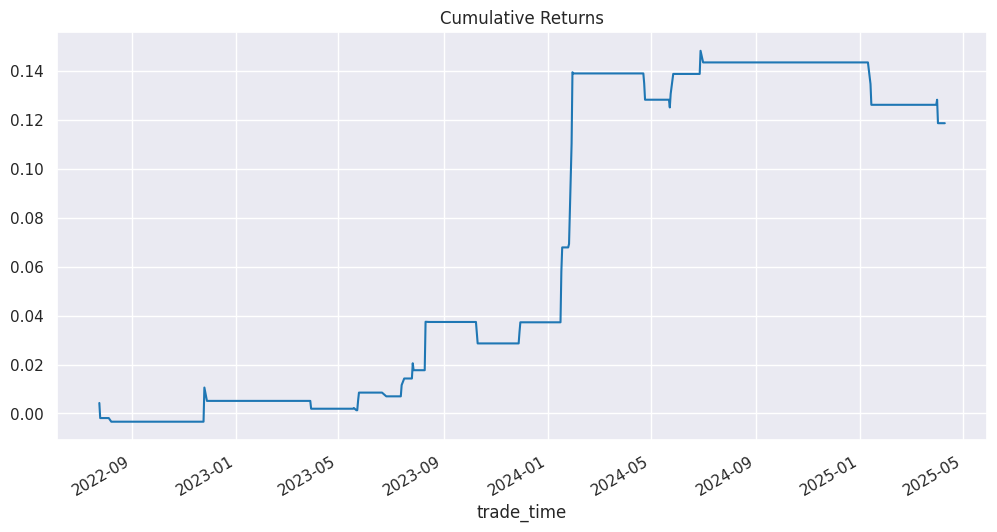

In [11]:
df1['ret'].cumsum().plot(figsize=(12, 6), title='Cumulative Returns')

In [12]:
import ultron.factor.empyrical as empyrical
empyrical.sharpe_ratio(returns=df1['ret'],
                                             period=empyrical.DAILY)

1.1189193718172725

In [34]:
res = []
for order in orders:
    rat1 = order_rate(order=order)
    s1 = order._asdict()
    s1['rate'] = rat1
    res.append(s1)

In [42]:
rates = [order_rate(order) for order in orders]

In [64]:
import numpy as np
n_sigma = 3
rates_series = np.array(rates)
mean_val = np.mean(rates_series)
std_val = np.std(rates_series)
lower_bound = mean_val - n_sigma * std_val
upper_bound = mean_val + n_sigma * std_val

In [65]:
rates_series = rates_series[(rates_series >= lower_bound)
                            & (rates_series <= upper_bound)]
rates_series

array([ 5.29069494e-02, -3.81174534e-02, -8.52656635e-04,  6.26702531e-03,
        5.74289756e-04, -8.08580330e-03, -4.58362830e-02, -4.60340000e-04,
       -2.07203666e-03,  2.87065675e-04, -2.33568573e-03, -1.14688010e-04,
       -8.89170626e-03, -1.48905848e-03, -8.03363758e-04, -8.60545825e-04,
        4.81826177e-02, -5.80876387e-04,  8.96866774e-03, -8.87546988e-04,
       -1.77189560e-03,  9.59408428e-03, -5.90001369e-05,  3.42178717e-04,
       -9.34209772e-03,  4.41282339e-02, -1.06886596e-04, -4.92438092e-04,
        3.17110424e-02, -1.92101815e-03, -1.35319901e-02,  5.29143014e-03,
       -4.27330708e-04, -8.23310422e-04,  3.43421768e-05,  3.93687007e-03,
       -9.07868555e-03,  6.59370310e-04, -3.61512204e-03, -4.51286354e-03,
       -7.89103523e-04,  1.82007587e-02,  2.66890168e-02,  4.05985966e-04,
        5.74756717e-02, -2.84675692e-03, -3.13750048e-04,  2.64071948e-02,
       -2.32558214e-04])

In [66]:
rates_series.mean() / rates_series.std()

0.19914043237908055

In [57]:
s1 = pd.DataFrame(res).loc[1:].sort_values(by='rate', ascending=False)
s1[s1['rate'] < 0.1]['rate'].sum()

s1['rate'].mean()

0.0018188176982320793

In [59]:
rates_series.max()

0.21345896988294194